<a href="https://colab.research.google.com/github/kimjh0607/Deep_Learning/blob/main/48_Tensorflow_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split = ['train[:80%]', 'train[80%:90%]', 'train[98%:]'],
    with_info = True,
    as_supervised = True
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


1


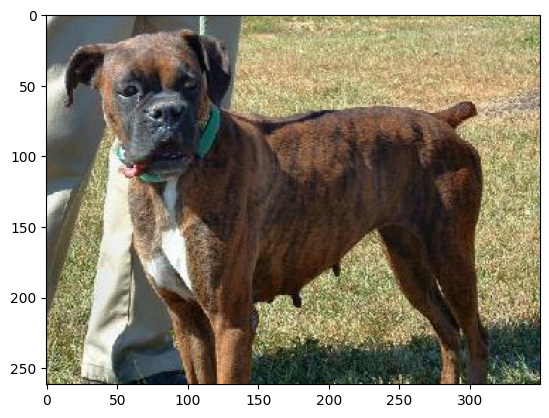

In [ ]:
for image, label in raw_train.take(1):
  plt.imshow(image)
  print(label.numpy())

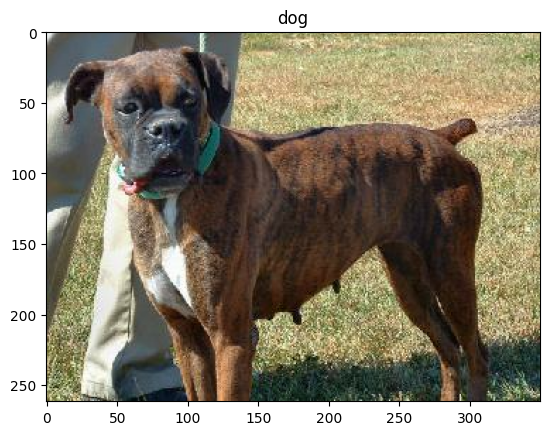

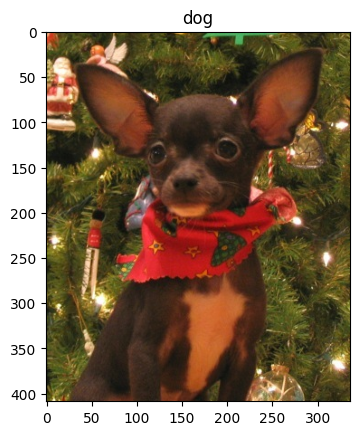

In [ ]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [ ]:
IMG_SIZE = 160 # 모든 이미지는 160x160 으로

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batchees = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
prediction_batch

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-0.3107329 ],
       [-1.4026366 ],
       [-0.34094715],
       [-1.4081421 ],
       [ 1.0723224 ],
       [ 0.32707992],
       [-0.295214  ],
       [ 0.3143741 ],
       [ 0.16701499],
       [ 1.0169404 ],
       [-0.2999277 ],
       [ 0.61208636],
       [-0.01794183],
       [-0.9358373 ],
       [-1.0582938 ],
       [ 0.7220876 ],
       [ 0.51564664],
       [ 0.9906943 ],
       [-0.35881022],
       [ 0.07575357],
       [-0.02117182],
       [-1.032091  ],
       [ 0.77307785],
       [ 0.1701983 ],
       [ 0.43094966],
       [-1.732526  ],
       [ 0.43969184],
       [-0.80692613],
       [ 1.3817161 ],
       [ 0.02101868],
       [ 0.64501226],
       [-0.17245486]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
initial_epochs = 10
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 3s 25ms/step - loss: 0.6506 - accuracy: 0.5859


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 21s 31ms/step - loss: 0.1959 - accuracy: 0.9177 - val_loss: 0.0911 - val_accuracy: 0.9678
Epoch 2/10
582/582 [==============================] - 18s 30ms/step - loss: 0.0732 - accuracy: 0.9742 - val_loss: 0.0678 - val_accuracy: 0.9742
Epoch 3/10
582/582 [==============================] - 18s 30ms/step - loss: 0.0592 - accuracy: 0.9788 - val_loss: 0.0597 - val_accuracy: 0.9785
Epoch 4/10
582/582 [==============================] - 18s 31ms/step - loss: 0.0530 - accuracy: 0.9811 - val_loss: 0.0555 - val_accuracy: 0.9798
Epoch 5/10
582/582 [==============================] - 18s 31ms/step - loss: 0.0493 - accuracy: 0.9822 - val_loss: 0.0530 - val_accuracy: 0.9811
Epoch 6/10
582/582 [==============================] - 18s 31ms/step - loss: 0.0469 - accuracy: 0.9832 - val_loss: 0.0513 - val_accuracy: 0.9819
Epoch 7/10
582/582 [==============================] - 18s 31ms/step - loss: 0.0452 - accuracy: 0.9839 - val_loss: 0.0501 - val_accuracy:

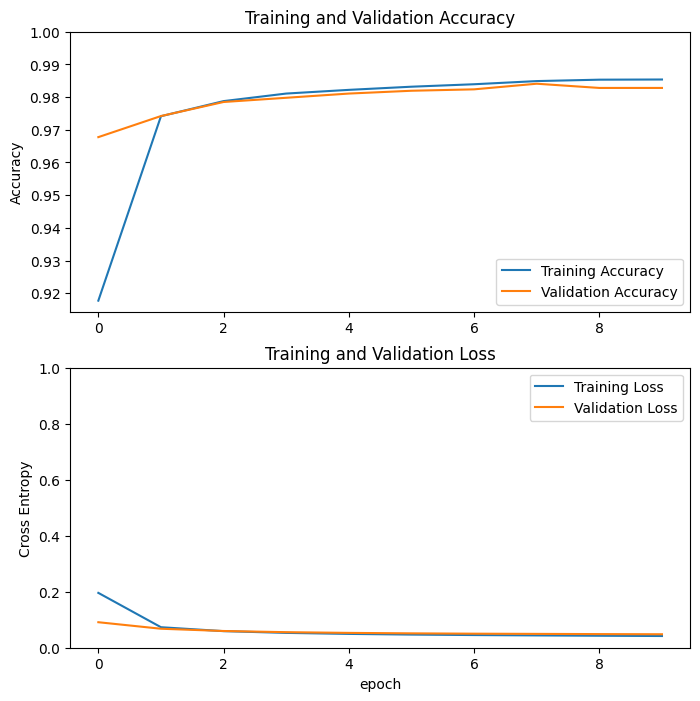

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

print(f'Number of layers in the base model : {len(base_model.layers)}')

Number of layers in the base model : 154


In [ ]:
# 100번째 층부터 튜닝가능하게 설정
fine_tune_at = 100

# 'fine_tune_at'층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# 학습 비율을 낮춤

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


In [ ]:
# epoch 10부터 시작.
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_batches,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_batches
)

Epoch 10/20
582/582 [==============================] - 32s 41ms/step - loss: 0.1299 - accuracy: 0.9514 - val_loss: 0.0681 - val_accuracy: 0.9815
Epoch 11/20
582/582 [==============================] - 24s 40ms/step - loss: 0.0681 - accuracy: 0.9732 - val_loss: 0.0529 - val_accuracy: 0.9815
Epoch 12/20
582/582 [==============================] - 24s 41ms/step - loss: 0.0541 - accuracy: 0.9782 - val_loss: 0.0482 - val_accuracy: 0.9832
Epoch 13/20
582/582 [==============================] - 23s 39ms/step - loss: 0.0362 - accuracy: 0.9856 - val_loss: 0.0492 - val_accuracy: 0.9828
Epoch 14/20
582/582 [==============================] - 23s 40ms/step - loss: 0.0321 - accuracy: 0.9880 - val_loss: 0.0503 - val_accuracy: 0.9807
Epoch 15/20
582/582 [==============================] - 24s 40ms/step - loss: 0.0232 - accuracy: 0.9915 - val_loss: 0.0479 - val_accuracy: 0.9832
Epoch 16/20
582/582 [==============================] - 24s 40ms/step - loss: 0.0205 - accuracy: 0.9923 - val_loss: 0.0479 - val_ac

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['loss']

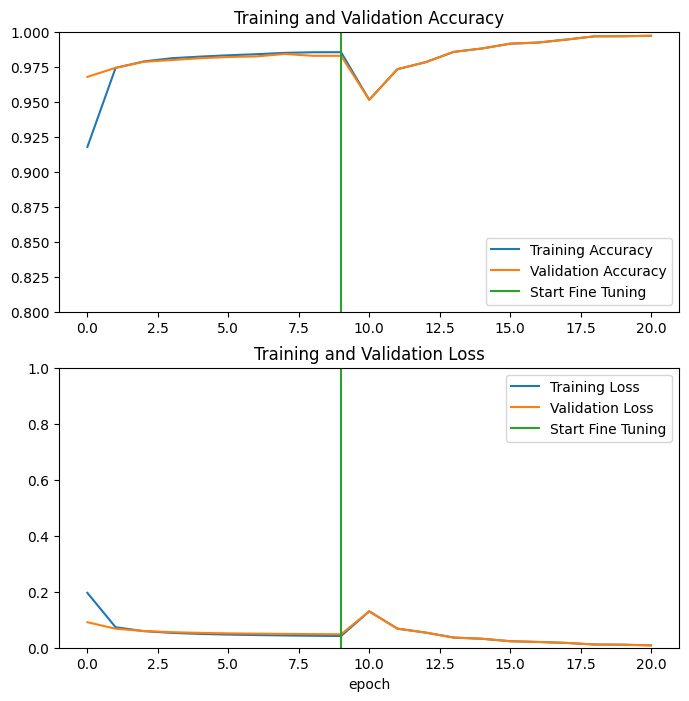

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

---

In [ ]:
!pip install -U tf-hub-nightly
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
classifier_url = url

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE + (3,))
])

classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3540265 (13.51 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


61306/61306 [==============================] - 0s 1us/step


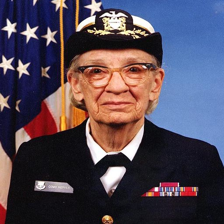

In [ ]:
import numpy as np
import PIL.Image as Image

url = "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg"
grace_hopper = tf.keras.utils.get_file('grace_hopper.jpg', origin=url)
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [ ]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

In [ ]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 871ms/step


(1, 1001)

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', origin=url)
imagenet_labels = np.array(open(labels_path).read().splitlines())

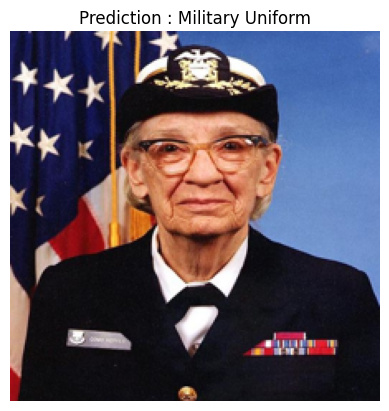

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title('Prediction : ' + predicted_class_name.title())

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_root = tf.keras.utils.get_file(
    'flower_photos', url, untar=True
)

228813984/228813984 [==============================] - 11s 0us/step


In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in image_data:
  print('Image batch shape : ',image_batch.shape)
  print('LAbel batch shape : ',label_batch.shape)
  break

Image batch shape :  (32, 224, 224, 3)
LAbel batch shape :  (32, 5)


In [ ]:
result_batch = classifier.predict(image_batch)
result_batch.shape

1/1 [==============================] - 1s 595ms/step


(32, 1001)

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['bee', 'boathouse', 'bell cote', 'bee', 'chiton', 'barn spider',
       'feather boa', 'daisy', 'daisy', 'pinwheel', 'bee', 'feather boa',
       'mushroom', 'abaya', 'orange', 'hip', 'bee', 'lumbermill', 'daisy',
       'daisy', 'daisy', 'daisy', 'sea urchin', 'buckeye', 'picket fence',
       'daisy', 'daisy', 'cardoon', 'birdhouse', 'barn spider', 'cardoon',
       'daisy'], dtype='<U30')

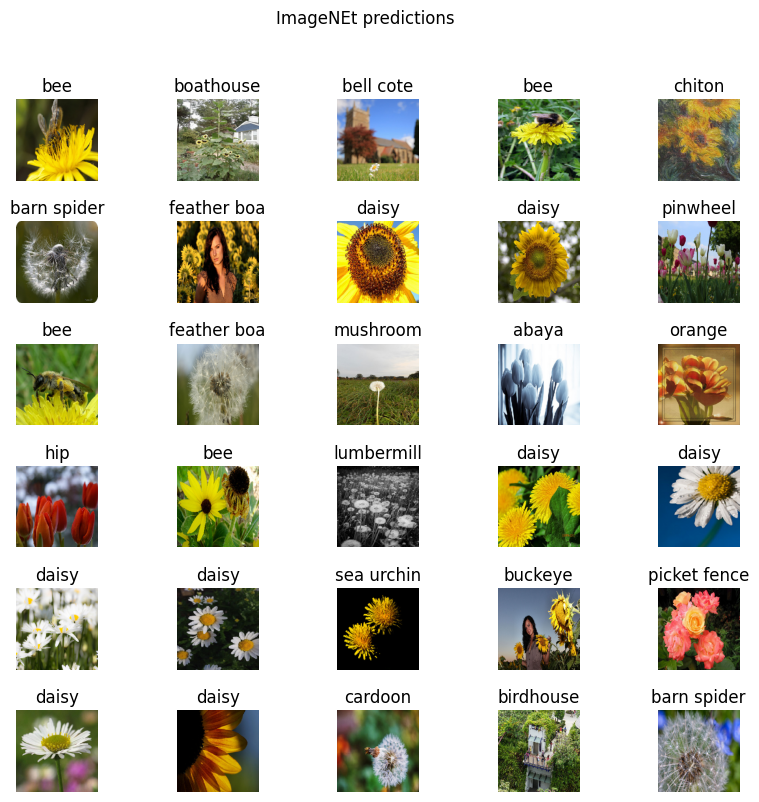

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')

_=plt.suptitle("ImageNEt predictions")

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [ ]:
feature_batch = feature_extractor_layer(image_batch)

print(feature_batch.shape)

(32, 1280)


In [ ]:
feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 5])

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(
    image_data,
    epochs=2,
    steps_per_epoch=steps_per_epoch,
    callbacks=[batch_stats_callback]
)

Epoch 1/2
115/115 [==============================] - 9s 78ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 2/2
115/115 [==============================] - 9s 82ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


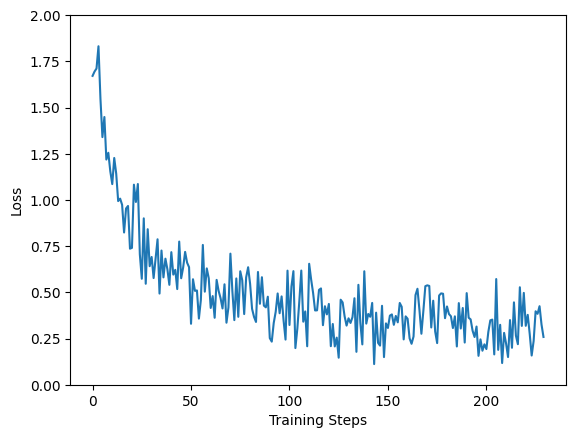

In [ ]:
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

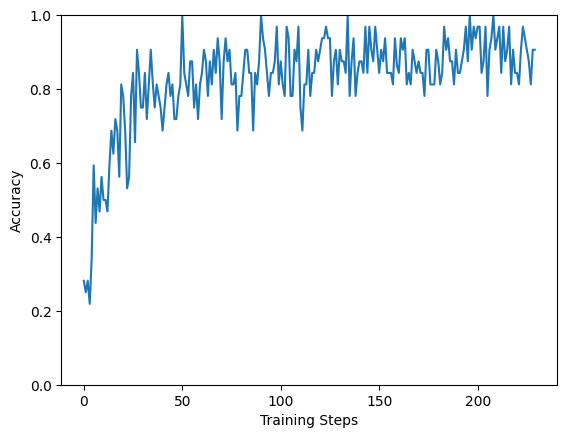

In [ ]:
plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Training Steps')
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

1/1 [==============================] - 0s 34ms/step


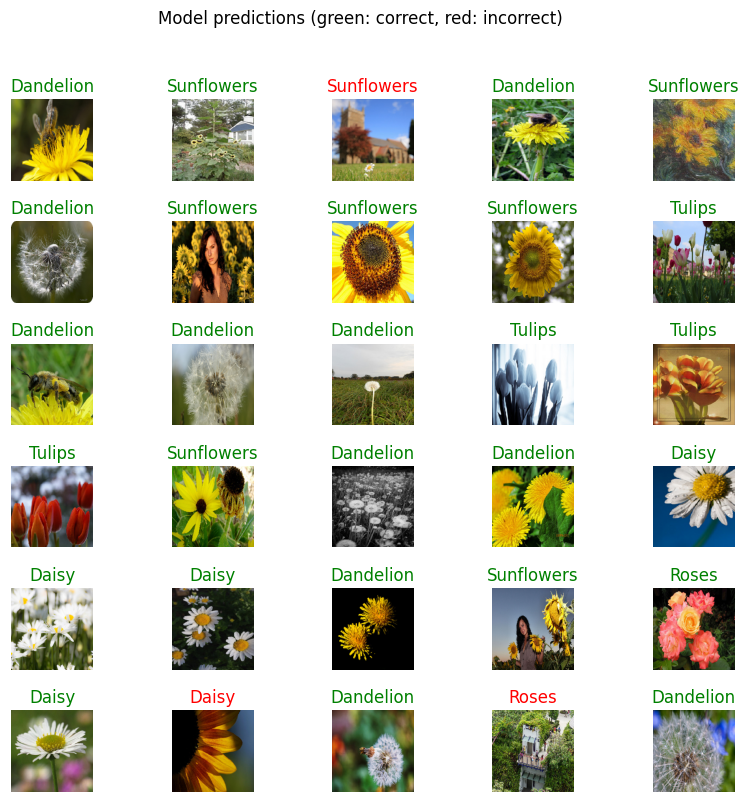

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_id[n] == label_id[n] else 'red'
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')

_=plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
import time
t = time.time()

export_path = "./{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

'./1701868023'